In [2]:
from src.process import *
from src.models import *
from src.utils import *
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import os 
import sys
from datasets import load_dataset, Dataset, load_from_disk
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = get_encoders()
display(HTML(df.to_html()))

,encoder,size,desc
0,all-MiniLM-L6-v2,384,"MiniLM is a compact distilled model with RoBERTa-Large as teacher, version with 6 layers (30M parameters). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."
1,all-mpnet-base-v2,768,"MPNet (110M parameters, same architecture as BERT-base) is a training method combining MLM (Bert) and PLM (XLNet). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."
2,gtr-t5-large,768,"T5-Base (220M parameters) is a text-to-text transformer pre-trained on Colossal Clean Crawled Corpus. To obtain the sentence transformer, the model is fine-tuned for semantic search: given a query/question, if can find relevant passages."
3,all-roberta-large-v1,1024,"The base model is Roberta (354M parameters). To obtain the sentence transformer, the model is fine-tuned on a set of 1B sentence pairs with the task: given a sentence from a pair, the model must predict which of a set of other randomly sampled sentences is matched with it."


In [32]:
idx_encoder = 2
encoder = df.iloc[idx_encoder]['encoder']
size_embedding = df.iloc[idx_encoder]['size']

In [44]:
_, _, test = load_data_embedded(encoder, test_only=True)

In [35]:
model = torch.load('models/' + 'biLSTM_200_4_' + encoder,  map_location=torch.device(device))
model = model.to(device)

In [36]:
get_model_stats(model, test, nb_cat=4)

(0.813953488372093,
 array([0.878     , 0.827     , 0.82672234, 0.80065359, 0.78002699,
        0.81105991, 0.81460674, 0.78705637, 0.77402597, 0.80804954,
        0.77826087, 0.80327869, 0.78431373, 0.8625    , 0.7254902 ,
        0.75609756, 0.86956522, 0.75      , 0.63636364, 0.66666667,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ]),
 array([0.89285714, 0.78333333, 0.84322034, 0.77777778, 0.79059829,
        0.83636364, 0.82180851, 0.78315412, 0.79354839, 0.78723404,
        0.81995885, 0.84265734, 0.88423645, 0.87333333, 0.80555556,
        0.86554622, 0.82222222, 0.69473684, 0.76666667, 0.9047619 ,
               nan,        nan,        nan,        nan, 0.76923077]),
 0.878,
 0.778)

In [206]:
## A toi de jouer

In [6]:
def get_model_stats(model, test, nb_cat=4):
    predictions = []
    for i in range(len(test)):
        emb = np.array(test[i]['embeddings'])
        emb = torch.from_numpy(emb).to(torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(emb)
        predictions.append(torch.argmax(pred, axis=1).cpu().numpy())
        
    max_len = max(map(len, test['act']))
    res = np.nan * np.ones(shape=(len(test), max_len))
    true_mat = np.nan * np.ones(shape=(len(test), max_len))
    pred_mat = np.nan * np.ones(shape=(len(test), max_len))
    res_len = np.zeros((max_len-1, 2), dtype=int)
    res_cat = np.zeros((nb_cat, 2), dtype=int)
    cat_pos = np.zeros((max_len, 4), dtype=int)
    res_last = 0

    for i in range(len(test)):
        true = np.array(test[i]['act']) - 1
        res[i, 0:len(true)] = true == predictions[i]
        true_mat[i, 0:len(true)] = true 
        pred_mat[i, 0:len(true)] = predictions[i] 
        res_len[len(true)-2, 0] += (true == predictions[i]).sum()
        res_len[len(true)-2, 1] += len(true)
        for j in range(len(true)):
            res_cat[true[j], 0] += predictions[i][j] == true[j]
            res_cat[true[j], 1] += 1
            cat_pos[j, true[j]] += 1
        res_last += predictions[i][-1] == true[-1]
        

    accuracy = np.nansum(res) / np.sum(~np.isnan(res))
    acc_per_position = np.nansum(res, axis=0) / np.sum(~np.isnan(res), axis=0)
    acc_per_len = res_len[:, 0] / res_len[:, 1]
    acc_first = acc_per_position[0]
    acc_last = res_last / len(test)
    return accuracy, acc_per_position, acc_per_len, acc_first, acc_last

In [7]:
plot = sns.lineplot(data= acc_per_position[:10], marker='o', linestyle='dashed', linewidth=0.6, markevery = [i for i in range(0, 10, 1)],label="Accuracy by position")
plot.set(xlabel = "Utterrance position", ylabel = "Accuracy")
plot.axhline(accuracy, color='r', linestyle='dashed', alpha=0.5, linewidth=0.7,label="Accuracy of the model")
plot.legend()
plt.show()

NameError: name 'acc_per_position' is not defined

/tmp/ipykernel_14463/1701191517.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(range(0,11,2))


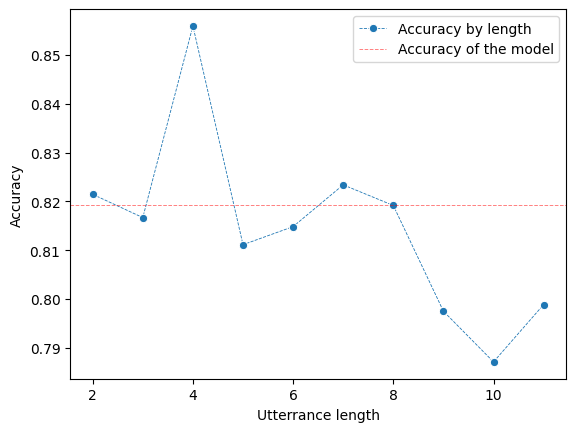

In [237]:
plot = sns.lineplot(data= acc_per_len[:10], marker='o', linestyle='dashed', linewidth=0.6, markevery = range(0, 10, 1),label="Accuracy by length")
plot.set(xlabel = "Utterrance length", ylabel = "Accuracy")
plot.axhline(accuracy, color='r', linestyle='dashed', alpha=0.5, linewidth=0.7,label="Accuracy of the model")
plot.set_xticklabels(range(0,11,2))
plot.legend()
plt.show()

In [243]:
# Proportion categories per position
cat_pos / cat_pos.sum(axis=1)[:,None]

array([[0.277     , 0.497     , 0.226     , 0.        ],
       [0.492     , 0.263     , 0.143     , 0.102     ],
       [0.41753653, 0.35803758, 0.16597077, 0.05845511],
       [0.53050109, 0.208061  , 0.1459695 , 0.11546841],
       [0.43184885, 0.29554656, 0.17139001, 0.10121457],
       [0.50844854, 0.21812596, 0.15975422, 0.11367127],
       [0.42696629, 0.30337079, 0.17228464, 0.09737828],
       [0.53862213, 0.19415449, 0.14822547, 0.11899791],
       [0.45974026, 0.25714286, 0.16623377, 0.11688312],
       [0.55108359, 0.16718266, 0.14551084, 0.13622291],
       [0.49565217, 0.21304348, 0.16521739, 0.12608696],
       [0.55737705, 0.1420765 , 0.1420765 , 0.15846995],
       [0.47058824, 0.28431373, 0.09803922, 0.14705882],
       [0.625     , 0.1625    , 0.125     , 0.0875    ],
       [0.39215686, 0.17647059, 0.23529412, 0.19607843],
       [0.51219512, 0.2195122 , 0.07317073, 0.19512195],
       [0.60869565, 0.13043478, 0.2173913 , 0.04347826],
       [0.3125    , 0.4375    ,

In [8]:
list_models = os.listdir('models/')
list_models = sorted(list_models, key = lambda x:x.split('_')[-1] + x.split('_')[0][1::])

res = []
for i, name in enumerate(tqdm(list_models)):
    model = torch.load('models/' + name,  map_location=torch.device(device))
    model = model.to(device)
    encoder = name.split('_')[-1]
    _, _, test = load_data_embedded(encoder, test_only=True)
    accuracy, acc_per_position, acc_per_len, acc_first, acc_last = get_model_stats(model, test)
    nb_parameters = get_nb_parameters(model)
    res.append([encoder, name.split('_')[0], '_'.join(name.split('_')[:-1]), nb_parameters, accuracy, acc_per_position, acc_per_len, acc_first, acc_last])
    
df_res = pd.DataFrame(res, columns=['encoder', 'model_type', 'model', 'nb_parameters', 'accuracy', 'acc_per_position', 'acc_per_len', 'acc_first', 'acc_last'])

100%|██████████| 40/40 [03:16<00:00,  4.91s/it]


In [9]:
df_res

,encoder,model_type,model,nb_parameters,accuracy,acc_per_position,acc_per_len,acc_first,acc_last
0,all-MiniLM-L6-v2,MLP,MLP_,25748,0.752842,"[0.851, 0.736, 0.7839248434237995, 0.721132897...","[0.7142857142857143, 0.7333333333333333, 0.781...",0.851,0.652
1,all-MiniLM-L6-v2,RNN,RNN_100_2,69204,0.754780,"[0.822, 0.757, 0.7630480167014614, 0.748366013...","[0.75, 0.725, 0.786723163841808, 0.71555555555...",0.822,0.709
2,all-MiniLM-L6-v2,RNN,RNN_50_4,37304,0.759432,"[0.833, 0.76, 0.767223382045929, 0.74618736383...","[0.7380952380952381, 0.775, 0.7909604519774012...",0.833,0.725
3,all-MiniLM-L6-v2,GRU,GRU_100_2,206804,0.768605,"[0.832, 0.77, 0.7839248434237995, 0.7636165577...","[0.7261904761904762, 0.75, 0.807909604519774, ...",0.832,0.729
4,all-MiniLM-L6-v2,LSTM,LSTM_100_2,275604,0.777649,"[0.849, 0.781, 0.7766179540709812, 0.766884531...","[0.7738095238095238, 0.7666666666666667, 0.810...",0.849,0.748
5,all-MiniLM-L6-v2,biGRU,biGRU_100_2,473604,0.784367,"[0.84, 0.796, 0.7985386221294363, 0.7690631808...","[0.7976190476190477, 0.8, 0.8305084745762712, ...",0.840,0.748
6,all-MiniLM-L6-v2,biLSTM,biLSTM_50_4,357204,0.792119,"[0.84, 0.798, 0.8100208768267223, 0.7777777777...","[0.8809523809523809, 0.8, 0.8347457627118644, ...",0.840,0.754
7,all-MiniLM-L6-v2,biRNN,biRNN_100_3,218804,0.780362,"[0.837, 0.778, 0.7922755741127349, 0.760348583...","[0.8333333333333334, 0.7833333333333333, 0.822...",0.837,0.763
8,all-MiniLM-L6-v2,biRNN,biRNN_200_3,717604,0.781912,"[0.824, 0.786, 0.7922755741127349, 0.760348583...","[0.8095238095238095, 0.775, 0.8248587570621468...",0.824,0.756
9,all-mpnet-base-v2,MLP,MLP_,50324,0.785788,"[0.859, 0.786, 0.8121085594989561, 0.760348583...","[0.8214285714285714, 0.7666666666666667, 0.819...",0.859,0.716


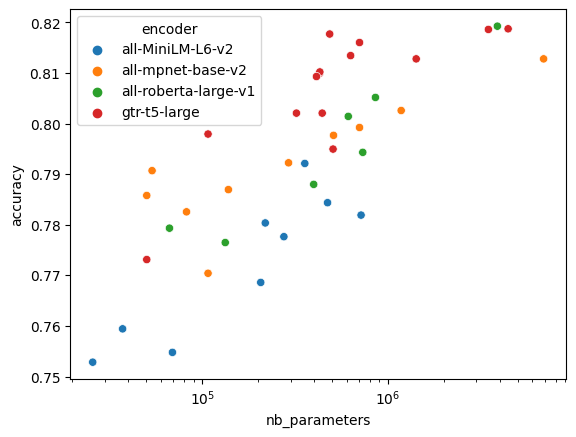

In [10]:
labels = df_res['encoder']
sns.scatterplot(x=df_res['nb_parameters'], y=df_res['accuracy'], hue=labels)
plt.xscale('log')

In [11]:
df_res_nodup = df_res.sort_values('accuracy', ascending=False).drop_duplicates(['encoder', 'model_type'])

In [12]:
dic_context={'MLP': 'None',
             'RNN': 'Past',
             'GRU': 'Past',
             'LSTM': 'Past',
             'biRNN': 'Full',
             'biLSTM': 'Full',
             'biGRU': 'Full',
}

dic_model={'MLP': 'MLP',
             'RNN': 'RNN',
             'GRU': 'GRU',
             'LSTM': 'LSTM',
             'biRNN': 'RNN',
             'biLSTM': 'LSTM',
             'biGRU': 'GRU',
}

In [13]:
df_res['context'] = df_res['model_type'].replace(dic_context)
df_res['Model type'] = df_res['model_type'].replace(dic_model)
df_res_nodup['context'] = df_res_nodup['model_type'].replace(dic_context)

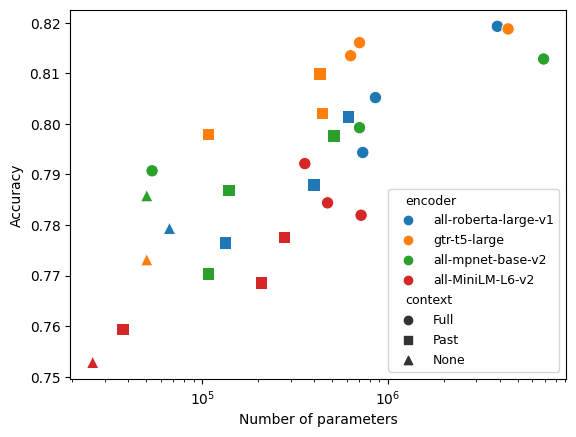

In [14]:
labels = df_res_nodup['encoder']
gfg = sns.scatterplot(x=df_res_nodup['nb_parameters'], y=df_res_nodup['accuracy'], hue=labels, style=df_res_nodup['context'], markers=['o', 's', '^'], s=80)
plt.xscale('log')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.setp(gfg.get_legend().get_texts(), fontsize='9') 
plt.savefig('images/acc_par.png', bbox_inches='tight')

In [15]:
df_res_nodup.sort_values(['encoder', 'model_type'])

,encoder,model_type,model,nb_parameters,accuracy,acc_per_position,acc_per_len,acc_first,acc_last,context
3,all-MiniLM-L6-v2,GRU,GRU_100_2,206804,0.768605,"[0.832, 0.77, 0.7839248434237995, 0.7636165577...","[0.7261904761904762, 0.75, 0.807909604519774, ...",0.832,0.729,Past
4,all-MiniLM-L6-v2,LSTM,LSTM_100_2,275604,0.777649,"[0.849, 0.781, 0.7766179540709812, 0.766884531...","[0.7738095238095238, 0.7666666666666667, 0.810...",0.849,0.748,Past
0,all-MiniLM-L6-v2,MLP,MLP_,25748,0.752842,"[0.851, 0.736, 0.7839248434237995, 0.721132897...","[0.7142857142857143, 0.7333333333333333, 0.781...",0.851,0.652,None
2,all-MiniLM-L6-v2,RNN,RNN_50_4,37304,0.759432,"[0.833, 0.76, 0.767223382045929, 0.74618736383...","[0.7380952380952381, 0.775, 0.7909604519774012...",0.833,0.725,Past
5,all-MiniLM-L6-v2,biGRU,biGRU_100_2,473604,0.784367,"[0.84, 0.796, 0.7985386221294363, 0.7690631808...","[0.7976190476190477, 0.8, 0.8305084745762712, ...",0.840,0.748,Full
6,all-MiniLM-L6-v2,biLSTM,biLSTM_50_4,357204,0.792119,"[0.84, 0.798, 0.8100208768267223, 0.7777777777...","[0.8809523809523809, 0.8, 0.8347457627118644, ...",0.840,0.754,Full
8,all-MiniLM-L6-v2,biRNN,biRNN_200_3,717604,0.781912,"[0.824, 0.786, 0.7922755741127349, 0.760348583...","[0.8095238095238095, 0.775, 0.8248587570621468...",0.824,0.756,Full
11,all-mpnet-base-v2,GRU,GRU_50_2,138504,0.786951,"[0.856, 0.8, 0.7849686847599165, 0.75816993464...","[0.8809523809523809, 0.75, 0.8107344632768362,...",0.856,0.745,Past
12,all-mpnet-base-v2,LSTM,LSTM_100_3,510004,0.797674,"[0.857, 0.813, 0.7870563674321504, 0.794117647...","[0.8690476190476191, 0.75, 0.8220338983050848,...",0.857,0.748,Past
9,all-mpnet-base-v2,MLP,MLP_,50324,0.785788,"[0.859, 0.786, 0.8121085594989561, 0.760348583...","[0.8214285714285714, 0.7666666666666667, 0.819...",0.859,0.716,None


In [16]:
df_500k = df_res[(df_res['nb_parameters'].between(400000,530000)) & (df_res['encoder']=='gtr-t5-large')].sort_values('accuracy')

In [17]:
df_500k

,encoder,model_type,model,nb_parameters,accuracy,acc_per_position,acc_per_len,acc_first,acc_last,context,Model type
27,gtr-t5-large,RNN,RNN_250_3,507004,0.794961,"[0.862, 0.807, 0.7985386221294363, 0.772331154...","[0.7976190476190477, 0.825, 0.8248587570621468...",0.862,0.750,Past,RNN
30,gtr-t5-large,GRU,GRU_100_4,443204,0.802067,"[0.87, 0.806, 0.8058455114822547, 0.7745098039...","[0.8333333333333334, 0.7833333333333333, 0.841...",0.870,0.768,Past,GRU
39,gtr-t5-large,biRNN,biRNN_150_2,412804,0.809302,"[0.868, 0.825, 0.8121085594989561, 0.808278867...","[0.8333333333333334, 0.8, 0.8418079096045198, ...",0.868,0.775,Full,RNN
31,gtr-t5-large,LSTM,LSTM_100_2,429204,0.809948,"[0.87, 0.828, 0.8110647181628392, 0.7984749455...","[0.8214285714285714, 0.8, 0.846045197740113, 0...",0.870,0.774,Past,LSTM
32,gtr-t5-large,biGRU,biGRU_60_3,430324,0.810207,"[0.868, 0.827, 0.8121085594989561, 0.795206971...","[0.8452380952380952, 0.8, 0.847457627118644, 0...",0.868,0.775,Full,GRU
37,gtr-t5-large,biLSTM,biLSTM_60_2,486244,0.817700,"[0.873, 0.829, 0.8131524008350731, 0.799564270...","[0.8452380952380952, 0.8166666666666667, 0.848...",0.873,0.783,Full,LSTM


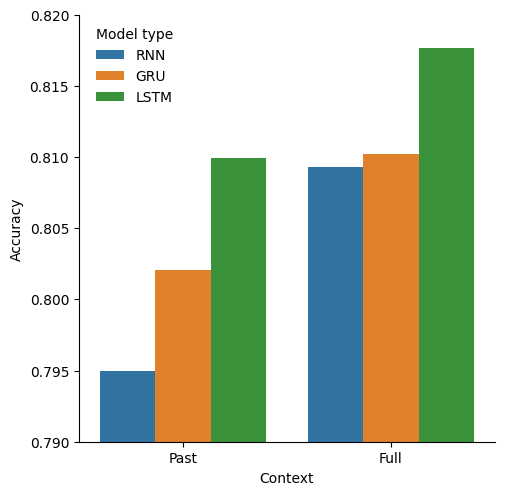

In [31]:
g = sns.catplot(data=df_500k, x="context", y="accuracy", hue="Model type", kind="bar")
g.set(ylim=(0.79, 0.82))
plt.xlabel("Context")
plt.ylabel("Accuracy")
sns.move_legend(g, "upper left", bbox_to_anchor=(0.14, 0., 0, 0.97))
plt.savefig('images/acc_500.png', bbox_inches='tight')